In [1]:
import gpflow
from steingp import SVGD, SteinGPR, RBF, rmse
from steingp.utils import train_test_idx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Simulate training data

In [2]:
rng = np.random.RandomState(123)
N = 100
D = 1
X = np.sort(rng.uniform(low=-5, high=5, size=(N, D)), axis=0)
Y = np.sin(X) + rng.normal(loc=0, scale=0.1, size=(N, D))

# Partition into train/test
train_idx, test_idx = train_test_idx(N, rng, train_prop=0.7)
Xtr, ytr = X[train_idx], Y[train_idx]
Xte, yte = X[test_idx], Y[test_idx]

## Define model

In [3]:
kern = gpflow.kernels.SquaredExponential()
m = SteinGPR((Xtr, ytr), kernel=kern, obs_noise=0.2)

## Instantiate and run SVGD

In [4]:
opt = SVGD(model=m, kernel=RBF(h=-1), n_particles=10, verbose=True)
opt.run(iterations=100)

100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


# Inspect particles

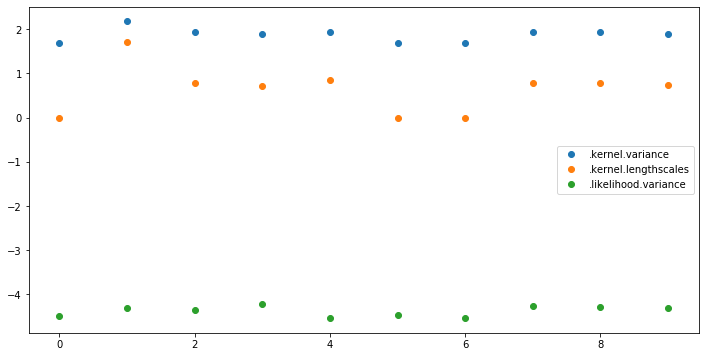

In [5]:
theta = opt.theta.numpy()
params = gpflow.utilities.parameter_dict(m)
fig, ax = plt.subplots(figsize=(12, 6))
for p, t in zip(params.keys(), theta):
    ax.plot(t, 'o', label=p)
ax.legend(loc='best')
plt.show()

# Make predictions

In [51]:
preds = m.predict(Xte, theta, 20)
mu = np.mean(preds, axis=0)
mu_lower = np.percentile(preds, 5, axis=0)
mu_higher = np.percentile(preds, 95, axis=0)

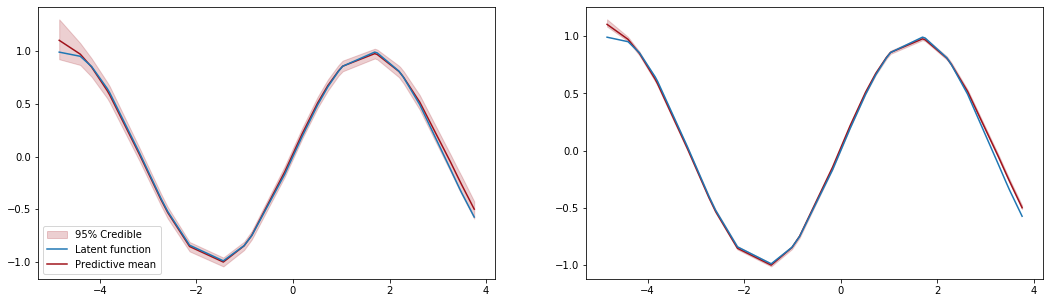

In [54]:
fig, ax = plt.subplots(figsize=(18, 5), nrows=1, ncols=2)
# for p in preds:
#     ax.plot(Xte, p, color='#a0121b', alpha = 0.1, label="Predictive samples")
ax[0].plot(Xte, mu, color='#a0121b', label="Predictive mean")
ax[0].fill_between(Xte.squeeze(), y1 = mu_lower, y2 = mu_higher, label="95% Credible", color='#a0121b', alpha=0.2)
ax[0].plot(Xte, np.sin(Xte), label='Latent function')
handles, labels = ax[0].get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax[0].legend(handles, labels, loc='best')

mu_y, sigma_y = m.predict_y(Xte)
ax[1].plot(Xte, mu, color='#a0121b')
ax[1].fill_between(Xte.squeeze(), mu_y.numpy().squeeze()-sigma_y.numpy().squeeze(), mu_y.numpy().squeeze()+sigma_y.numpy().squeeze(), color='#a0121b', alpha=0.2)
ax[1].plot(Xte, np.sin(Xte))

## Quantify prediction

In [61]:
pred_rmse = rmse(mu.reshape(-1, 1), yte)
print(f"Predictive RMSE: {pred_rmse}")

Predictive RMSE: 0.007932386476244956
